# Случайное дерево

## Подготовка данных

In [1]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, classification_report,
                             r2_score, mean_absolute_error, mean_squared_error, roc_auc_score)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("="*70)
print("ЛАБОРАТОРНАЯ РАБОТА №4: СЛУЧАЙНЫЙ ЛЕС (RANDOM FOREST)")
print("="*70)

ЛАБОРАТОРНАЯ РАБОТА №4: СЛУЧАЙНЫЙ ЛЕС (RANDOM FOREST)


In [2]:
df_class = pd.read_csv('./data/beans/Dry_Bean_Dataset.csv')
df_reg = pd.read_csv('./data/football/players_3120.csv')

X_cls = df_class.drop('Class', axis=1)
y_cls = df_class['Class']

le = LabelEncoder()
y_cls_encoded = le.fit_transform(y_cls)

X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(
    X_cls, y_cls_encoded, test_size=0.2, random_state=42, stratify=y_cls_encoded
)

scaler_cls = StandardScaler()
X_cls_train_scaled = scaler_cls.fit_transform(X_cls_train)
X_cls_test_scaled = scaler_cls.transform(X_cls_test)


In [3]:

def value_to_float(value_str):
    try:
        if pd.isna(value_str):
            return np.nan
        
        value_str = str(value_str).strip()
        
        if value_str.startswith('€'):
            value_str = value_str[1:]
        
        multiplier = 1
        if value_str.endswith('M'):
            multiplier = 1_000_000
            value_str = value_str[:-1]
        elif value_str.endswith('K'):
            multiplier = 1_000
            value_str = value_str[:-1]
        
        return float(value_str) * multiplier
    except Exception as e:
        print(f"Ошибка преобразования '{value_str}': {e}")
        return np.nan


df_reg['Value_numeric'] = df_reg['Value'].apply(value_to_float)

def height_to_cm(height_str):
    try:
        if pd.isna(height_str):
            return np.nan
        height_str = str(height_str)
        import re
        match = re.search(r'(\d+)cm', height_str)
        if match:
            return float(match.group(1))
        return np.nan
    except:
        return np.nan

def weight_to_kg(weight_str):
    try:
        if pd.isna(weight_str):
            return np.nan
        weight_str = str(weight_str)
        import re
        match = re.search(r'(\d+)kg', weight_str)
        if match:
            return float(match.group(1))
        return np.nan
    except:
        return np.nan

df_reg['Height_cm'] = df_reg['Height'].apply(height_to_cm)
df_reg['Weight_kg'] = df_reg['Weight'].apply(weight_to_kg)

numeric_features = [
    'Age', 
    'Overall rating', 
    'Potential',
    'Height_cm',
    'Weight_kg',
    'Crossing', 
    'Finishing', 
    'Short passing', 
    'Dribbling',
    'Acceleration', 
    'Sprint speed', 
    'Stamina', 
    'Strength',
    'Long shots',
    'Interceptions',
    'Heading accuracy',
    'Ball control',
    'Reactions',
    'Composure',
    'Vision',
    'Aggression',
    'Penalties'
]

existing_features = [col for col in numeric_features if col in df_reg.columns]
print(f"\nИспользуем признаки ({len(existing_features)}): {existing_features}")

X_reg = df_reg[existing_features].copy()

for col in X_reg.columns:
    X_reg[col] = pd.to_numeric(X_reg[col], errors='coerce')

X_reg = X_reg.fillna(X_reg.median())

y_reg = df_reg['Value_numeric']

valid_indices = y_reg.notna()
X_reg = X_reg[valid_indices]
y_reg = y_reg[valid_indices]

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

scaler_reg = StandardScaler()
X_reg_train_scaled = scaler_reg.fit_transform(X_reg_train)
X_reg_test_scaled = scaler_reg.transform(X_reg_test)


Используем признаки (22): ['Age', 'Overall rating', 'Potential', 'Height_cm', 'Weight_kg', 'Crossing', 'Finishing', 'Short passing', 'Dribbling', 'Acceleration', 'Sprint speed', 'Stamina', 'Strength', 'Long shots', 'Interceptions', 'Heading accuracy', 'Ball control', 'Reactions', 'Composure', 'Vision', 'Aggression', 'Penalties']


# 2.1 Классификация 

Обучение бейзлайна и оценка качества


КЛАССИФИКАЦИЯ: Случайный лес (бейзлайн)
Accuracy (случайный лес): 0.9214
F1-score (macro): 0.9339

Топ-10 самых важных признаков (случайный лес, классификация):
            feature  importance
14     ShapeFactor3    0.109092
11      Compactness    0.094132
1         Perimeter    0.088497
12     ShapeFactor1    0.083215
6        ConvexArea    0.082785
2   MajorAxisLength    0.077070
3   MinorAxisLength    0.075838
5      Eccentricity    0.064215
7     EquivDiameter    0.059733
0              Area    0.057408


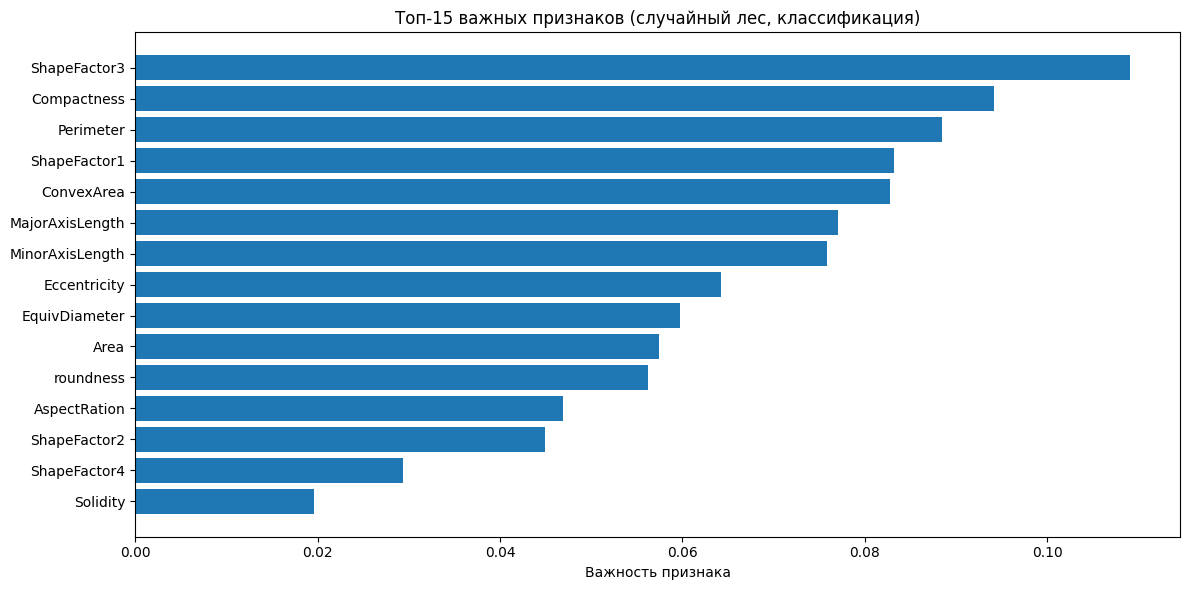

In [4]:
print("\n" + "="*70)
print("КЛАССИФИКАЦИЯ: Случайный лес (бейзлайн)")
print("="*70)

rf_cls_baseline = RandomForestClassifier(
    n_estimators=100,  
    random_state=42,
    n_jobs=-1  
)

rf_cls_baseline.fit(X_cls_train_scaled, y_cls_train)
y_cls_pred_rf = rf_cls_baseline.predict(X_cls_test_scaled)
y_cls_prob_rf = rf_cls_baseline.predict_proba(X_cls_test_scaled)

acc_rf_cls = accuracy_score(y_cls_test, y_cls_pred_rf)
f1_rf_cls = f1_score(y_cls_test, y_cls_pred_rf, average='macro')

print(f"Accuracy (случайный лес): {acc_rf_cls:.4f}")
print(f"F1-score (macro): {f1_rf_cls:.4f}")

feature_importance_rf_cls = pd.DataFrame({
    'feature': X_cls.columns,
    'importance': rf_cls_baseline.feature_importances_
}).sort_values('importance', ascending=False)

print("\nТоп-10 самых важных признаков (случайный лес, классификация):")
print(feature_importance_rf_cls.head(10))

plt.figure(figsize=(12, 6))
top_features = feature_importance_rf_cls.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.gca().invert_yaxis()
plt.xlabel('Важность признака')
plt.title('Топ-15 важных признаков (случайный лес, классификация)')
plt.tight_layout()
plt.show()

# 2.1 Регрессия

In [5]:
print("\n" + "="*70)
print("РЕГРЕССИЯ: Случайный лес (бейзлайн)")
print("="*70)

rf_reg_baseline = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

y_reg_train_log = np.log1p(y_reg_train)

rf_reg_baseline.fit(X_reg_train_scaled, y_reg_train_log)

y_reg_pred_log_rf = rf_reg_baseline.predict(X_reg_test_scaled)
y_reg_pred_rf = np.exp(y_reg_pred_log_rf) - 1

r2_rf_reg = r2_score(y_reg_test, y_reg_pred_rf)
mae_rf_reg = mean_absolute_error(y_reg_test, y_reg_pred_rf)
rmse_rf_reg = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_rf))

print(f"R² (случайный лес): {r2_rf_reg:.4f}")
print(f"MAE: {mae_rf_reg:,.0f} евро ({mae_rf_reg/1_000_000:.2f} млн евро)")
print(f"RMSE: {rmse_rf_reg:,.0f} евро ({rmse_rf_reg/1_000_000:.2f} млн евро)")

feature_importance_rf_reg = pd.DataFrame({
    'feature': X_reg.columns,
    'importance': rf_reg_baseline.feature_importances_
}).sort_values('importance', ascending=False)

print("\nТоп-10 самых важных признаков (случайный лес, регрессия):")
print(feature_importance_rf_reg.head(10))


РЕГРЕССИЯ: Случайный лес (бейзлайн)
R² (случайный лес): 0.8515
MAE: 2,072,117 евро (2.07 млн евро)
RMSE: 6,423,383 евро (6.42 млн евро)

Топ-10 самых важных признаков (случайный лес, регрессия):
           feature  importance
2        Potential    0.117249
17       Reactions    0.116343
0              Age    0.091559
1   Overall rating    0.060977
18       Composure    0.050653
7    Short passing    0.046913
11         Stamina    0.045772
19          Vision    0.042739
13      Long shots    0.040437
14   Interceptions    0.039406


# 3 Улучшение бейзлайна

## Формулировка гипотез:

### Для СЛУЧАЙНОГО ЛЕСА (классификация):

H1: Увеличение количества деревьев (n_estimators) улучшит качество, но увеличит время обучения.

H2: Настройка максимальной глубины деревьев (max_depth) важна для баланса пере/недообучения.

H3: Критерий разделения (criterion) влияет на качество леса.

H4: Ограничение признаков для каждого разделения (max_features) уменьшит корреляцию между деревьями.

In [6]:
print("\n" + "="*70)
print("3. УЛУЧШЕНИЕ БЕЙЗЛАЙНА ДЛЯ СЛУЧАЙНОГО ЛЕСА")
print("="*70)

print("\n" + "-"*70)
print("КЛАССИФИКАЦИЯ: Улучшение случайного леса")
print("-"*70)

param_grid_rf_cls = {
    'n_estimators': [50, 100, 200],  # H1: Количество деревьев
    'max_depth': [10, 20, 30, None],  # H2: Максимальная глубина
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],  # Важный параметр
    'criterion': ['gini', 'entropy'],  # H3: Критерий разделения
    'max_features': ['sqrt', 'log2', None],  # H4: Признаки для разделения
    'bootstrap': [True, False]  # Бутстрап выборки
}

param_grid_rf_cls_simple = {
    'n_estimators': [100, 200],
    'max_depth': [20, 30, None],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search_rf_cls = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid_rf_cls_simple,
    cv=3,  # Уменьшаем кросс-валидацию для скорости
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search_rf_cls.fit(X_cls_train_scaled, y_cls_train)

print(f"\nЛучшие параметры случайного леса (классификация):")
for param, value in grid_search_rf_cls.best_params_.items():
    print(f"  {param}: {value}")

rf_cls_improved = grid_search_rf_cls.best_estimator_
y_cls_pred_rf_imp = rf_cls_improved.predict(X_cls_test_scaled)

acc_rf_cls_imp = accuracy_score(y_cls_test, y_cls_pred_rf_imp)
f1_rf_cls_imp = f1_score(y_cls_test, y_cls_pred_rf_imp, average='macro')

print(f"\nРезультаты улучшенного случайного леса (классификация):")
print(f"Accuracy: {acc_rf_cls_imp:.4f}")
print(f"F1-score (macro): {f1_rf_cls_imp:.4f}")

print(f"\nУлучшение по сравнению с бейзлайном:")
print(f"  Accuracy: {acc_rf_cls_imp - acc_rf_cls:+.4f}")
print(f"  F1-score: {f1_rf_cls_imp - f1_rf_cls:+.4f}")



3. УЛУЧШЕНИЕ БЕЙЗЛАЙНА ДЛЯ СЛУЧАЙНОГО ЛЕСА

----------------------------------------------------------------------
КЛАССИФИКАЦИЯ: Улучшение случайного леса
----------------------------------------------------------------------
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Лучшие параметры случайного леса (классификация):
  max_depth: 30
  max_features: sqrt
  min_samples_leaf: 1
  n_estimators: 100

Результаты улучшенного случайного леса (классификация):
Accuracy: 0.9214
F1-score (macro): 0.9339

Улучшение по сравнению с бейзлайном:
  Accuracy: +0.0000
  F1-score: +0.0000


### Для СЛУЧАЙНОГО ЛЕСА (регрессия):

H1: Оптимальное количество деревьев находится в диапазоне 100-300.

H2: min_samples_leaf критически важен для стабильности предсказаний.

H3: Использование bootstrap выборок улучшает обобщающую способность.

H4: Параметр max_samples контролирует размер бутстрап выборок.


In [7]:
print("\n" + "-"*70)
print("РЕГРЕССИЯ: Улучшение случайного леса")
print("-"*70)

param_grid_rf_reg = {
    'n_estimators': [100, 200, 300],  # H1: Количество деревьев
    'max_depth': [10, 20, 30, None],  # Глубина деревьев
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],  # H2: Минимальное в листе
    'max_features': ['sqrt', 'log2', None],  # Признаки для разделения
    'bootstrap': [True, False],  # H3: Бутстрап выборки
    'max_samples': [0.5, 0.7, 1.0]  # H4: Размер бутстрап выборок
}

param_grid_rf_reg_simple = {
    'n_estimators': [100, 200],
    'max_depth': [20, 30, None],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search_rf_reg = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid_rf_reg_simple,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search_rf_reg.fit(X_reg_train_scaled, y_reg_train_log)

print(f"\nЛучшие параметры случайного леса (регрессия):")
for param, value in grid_search_rf_reg.best_params_.items():
    print(f"  {param}: {value}")

rf_reg_improved = grid_search_rf_reg.best_estimator_

y_reg_pred_log_rf_imp = rf_reg_improved.predict(X_reg_test_scaled)
y_reg_pred_rf_imp = np.exp(y_reg_pred_log_rf_imp) - 1

r2_rf_reg_imp = r2_score(y_reg_test, y_reg_pred_rf_imp)
mae_rf_reg_imp = mean_absolute_error(y_reg_test, y_reg_pred_rf_imp)
rmse_rf_reg_imp = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_rf_imp))

print(f"\nРезультаты улучшенного случайного леса (регрессия):")
print(f"R²: {r2_rf_reg_imp:.4f}")
print(f"MAE: {mae_rf_reg_imp:,.0f} евро ({mae_rf_reg_imp/1_000_000:.2f} млн евро)")
print(f"RMSE: {rmse_rf_reg_imp:,.0f} евро ({rmse_rf_reg_imp/1_000_000:.2f} млн евро)")

# Сравнение с бейзлайном
print(f"\nУлучшение по сравнению с бейзлайном:")
print(f"  R²: {r2_rf_reg_imp - r2_rf_reg:+.4f}")
print(f"  MAE: {(mae_rf_reg - mae_rf_reg_imp)/1_000_000:+.2f} млн евро (уменьшение)")


----------------------------------------------------------------------
РЕГРЕССИЯ: Улучшение случайного леса
----------------------------------------------------------------------
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Лучшие параметры случайного леса (регрессия):
  max_depth: 20
  max_features: sqrt
  min_samples_leaf: 2
  n_estimators: 100

Результаты улучшенного случайного леса (регрессия):
R²: 0.8496
MAE: 2,963,016 евро (2.96 млн евро)
RMSE: 6,465,641 евро (6.47 млн евро)

Улучшение по сравнению с бейзлайном:
  R²: -0.0020
  MAE: -0.89 млн евро (уменьшение)



СРАВНЕНИЕ: БЕЙЗЛАЙН vs УЛУЧШЕННЫЕ МОДЕЛИ

Модель (классификация)              Accuracy        F1-score        Улучшение F1   
----------------------------------- --------------- --------------- ---------------
Случ.лес (бейзлайн)                 0.9214          0.9339          -              
Случ.лес (улучшенный)               0.9214          0.9339          +0.0000        

Модель (регрессия)                  R²              MAE (млн €)     Улучшение R²   
----------------------------------- --------------- --------------- ---------------
Случ.лес (бейзлайн)                 0.8515          2.07            -              
Случ.лес (улучшенный)               0.8496          2.96            -0.0020        


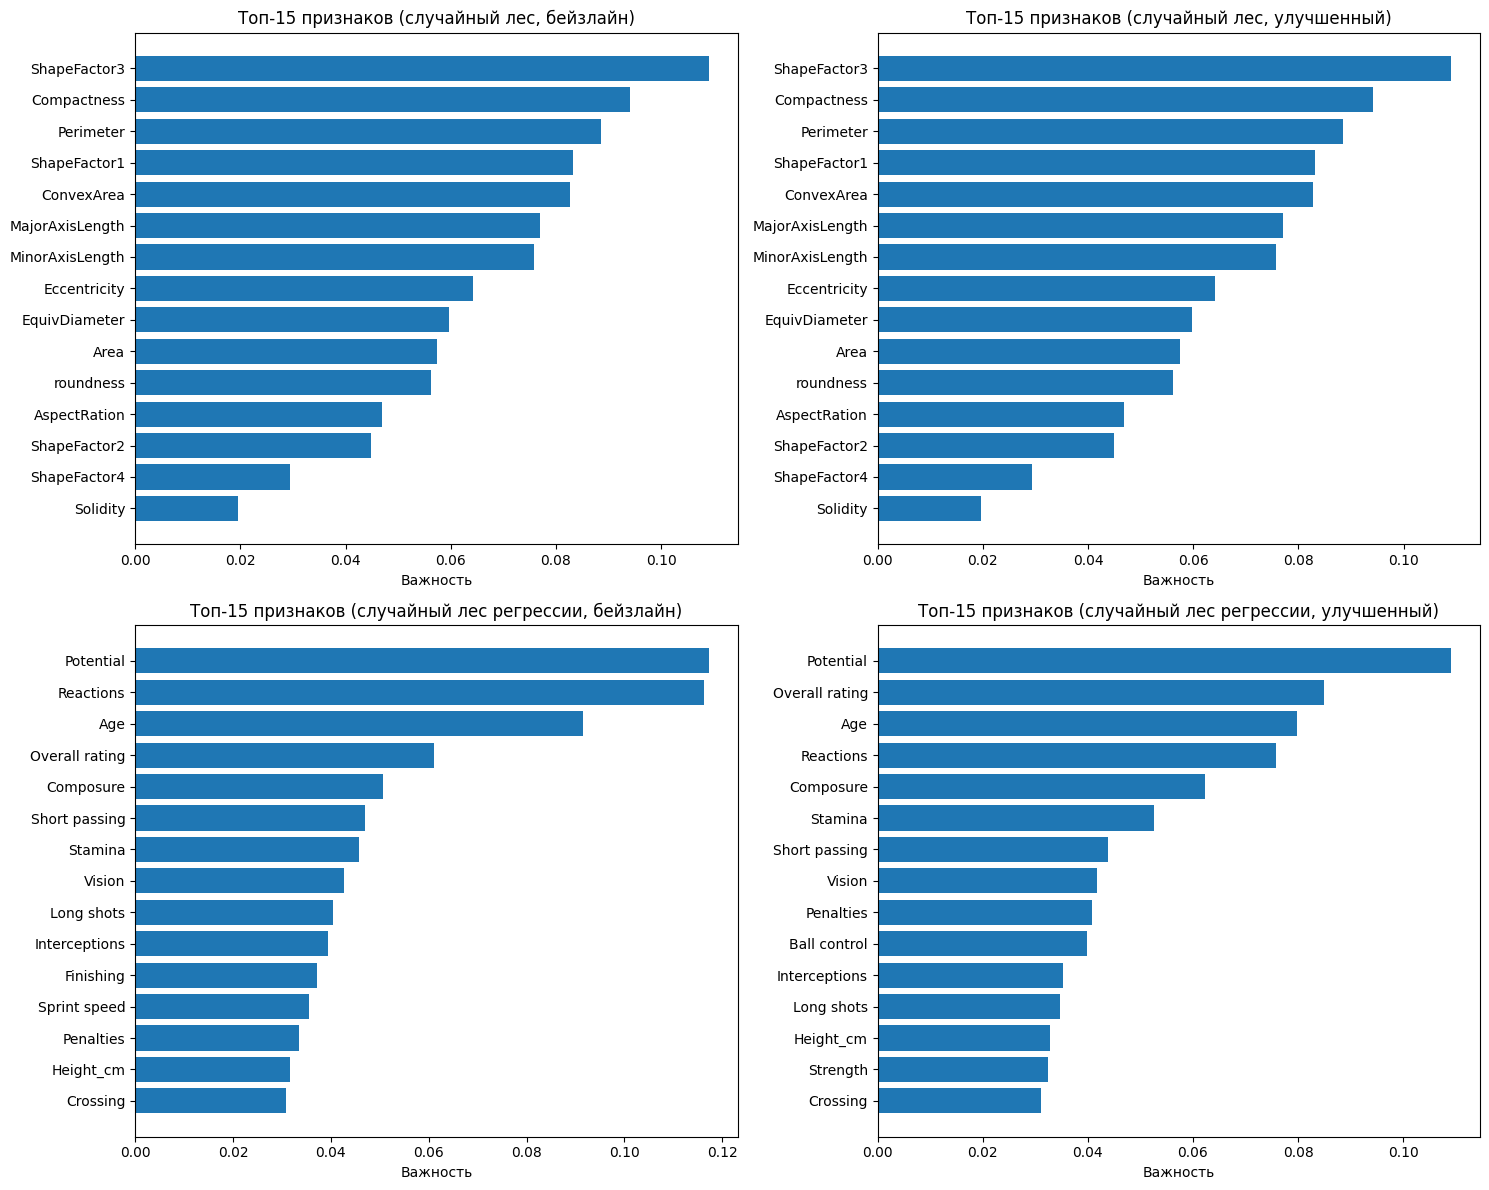


АНАЛИЗ СТАБИЛЬНОСТИ ПРЕДСКАЗАНИЙ

Анализ согласованности деревьев в лесу (классификация):
Количество деревьев: 100
Размерность предсказаний: (100, 2723)
Среднее согласие деревьев: 91.99%
Минимальное согласие: 38.00%
Максимальное согласие: 100.00%


In [8]:
print("\n" + "="*70)
print("СРАВНЕНИЕ: БЕЙЗЛАЙН vs УЛУЧШЕННЫЕ МОДЕЛИ")
print("="*70)

print(f"\n{'Модель (классификация)':<35} {'Accuracy':<15} {'F1-score':<15} {'Улучшение F1':<15}")
print(f"{'-'*35:<35} {'-'*15:<15} {'-'*15:<15} {'-'*15:<15}")

print(f"{'Случ.лес (бейзлайн)':<35} {acc_rf_cls:<15.4f} {f1_rf_cls:<15.4f} {'-':<15}")
print(f"{'Случ.лес (улучшенный)':<35} {acc_rf_cls_imp:<15.4f} {f1_rf_cls_imp:<15.4f} {f1_rf_cls_imp - f1_rf_cls:<+15.4f}")

print(f"\n{'Модель (регрессия)':<35} {'R²':<15} {'MAE (млн €)':<15} {'Улучшение R²':<15}")
print(f"{'-'*35:<35} {'-'*15:<15} {'-'*15:<15} {'-'*15:<15}")

print(f"{'Случ.лес (бейзлайн)':<35} {r2_rf_reg:<15.4f} {mae_rf_reg/1_000_000:<15.2f} {'-':<15}")
print(f"{'Случ.лес (улучшенный)':<35} {r2_rf_reg_imp:<15.4f} {mae_rf_reg_imp/1_000_000:<15.2f} {r2_rf_reg_imp - r2_rf_reg:<+15.4f}")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

importance_rf_cls_baseline = pd.DataFrame({
    'feature': X_cls.columns,
    'importance': rf_cls_baseline.feature_importances_
}).sort_values('importance', ascending=False).head(15)

axes[0, 0].barh(range(len(importance_rf_cls_baseline)), importance_rf_cls_baseline['importance'])
axes[0, 0].set_yticks(range(len(importance_rf_cls_baseline)))
axes[0, 0].set_yticklabels(importance_rf_cls_baseline['feature'])
axes[0, 0].invert_yaxis()
axes[0, 0].set_xlabel('Важность')
axes[0, 0].set_title('Топ-15 признаков (случайный лес, бейзлайн)')

importance_rf_cls_improved = pd.DataFrame({
    'feature': X_cls.columns,
    'importance': rf_cls_improved.feature_importances_
}).sort_values('importance', ascending=False).head(15)

axes[0, 1].barh(range(len(importance_rf_cls_improved)), importance_rf_cls_improved['importance'])
axes[0, 1].set_yticks(range(len(importance_rf_cls_improved)))
axes[0, 1].set_yticklabels(importance_rf_cls_improved['feature'])
axes[0, 1].invert_yaxis()
axes[0, 1].set_xlabel('Важность')
axes[0, 1].set_title('Топ-15 признаков (случайный лес, улучшенный)')

importance_rf_reg_baseline = pd.DataFrame({
    'feature': X_reg.columns,
    'importance': rf_reg_baseline.feature_importances_
}).sort_values('importance', ascending=False).head(15)

axes[1, 0].barh(range(len(importance_rf_reg_baseline)), importance_rf_reg_baseline['importance'])
axes[1, 0].set_yticks(range(len(importance_rf_reg_baseline)))
axes[1, 0].set_yticklabels(importance_rf_reg_baseline['feature'])
axes[1, 0].invert_yaxis()
axes[1, 0].set_xlabel('Важность')
axes[1, 0].set_title('Топ-15 признаков (случайный лес регрессии, бейзлайн)')

importance_rf_reg_improved = pd.DataFrame({
    'feature': X_reg.columns,
    'importance': rf_reg_improved.feature_importances_
}).sort_values('importance', ascending=False).head(15)

axes[1, 1].barh(range(len(importance_rf_reg_improved)), importance_rf_reg_improved['importance'])
axes[1, 1].set_yticks(range(len(importance_rf_reg_improved)))
axes[1, 1].set_yticklabels(importance_rf_reg_improved['feature'])
axes[1, 1].invert_yaxis()
axes[1, 1].set_xlabel('Важность')
axes[1, 1].set_title('Топ-15 признаков (случайный лес регрессии, улучшенный)')

plt.tight_layout()
plt.show()

# Анализ стабильности предсказаний
print("\n" + "="*70)
print("АНАЛИЗ СТАБИЛЬНОСТИ ПРЕДСКАЗАНИЙ")
print("="*70)

# Для случайного леса можно получить предсказания отдельных деревьев
print("\nАнализ согласованности деревьев в лесу (классификация):")

# Получаем предсказания всех деревьев
tree_predictions_cls = np.array([tree.predict(X_cls_test_scaled) 
                                 for tree in rf_cls_improved.estimators_])

# Анализ согласованности
print(f"Количество деревьев: {len(rf_cls_improved.estimators_)}")
print(f"Размерность предсказаний: {tree_predictions_cls.shape}")

# Процент деревьев, согласных с итоговым предсказанием
agreement_percentages = []
for i in range(len(y_cls_test)):
    final_pred = y_cls_pred_rf_imp[i]
    tree_votes = tree_predictions_cls[:, i]
    agreement = np.mean(tree_votes == final_pred)
    agreement_percentages.append(agreement)

print(f"Среднее согласие деревьев: {np.mean(agreement_percentages):.2%}")
print(f"Минимальное согласие: {np.min(agreement_percentages):.2%}")
print(f"Максимальное согласие: {np.max(agreement_percentages):.2%}")

# Имплементация

In [9]:
import numpy as np
from collections import Counter

class OptimizedDecisionTreeNode:
    """Оптимизированный узел дерева"""
    def __init__(self, feature_idx=None, threshold=None, value=None, 
                 left=None, right=None, indices=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.value = value
        self.left = left
        self.right = right
        self.indices = indices  # Сохраняем индексы для быстрого доступа

class OptimizedDecisionTreeClassifier:
    """
    ОПТИМИЗИРОВАННАЯ реализация решающего дерева для классификации
    """
    def __init__(self, max_depth=None, min_samples_split=2, 
                 min_samples_leaf=1, criterion='gini', max_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.max_features = max_features
        self.tree = None
        self.n_classes = None
        
    def _calculate_impurity(self, y):
        """Быстрое вычисление неопределенности"""
        if len(y) == 0:
            return 0
            
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        
        if self.criterion == 'gini':
            return 1.0 - np.sum(probabilities ** 2)
        else:  # entropy
            return -np.sum(probabilities * np.log2(probabilities + 1e-10))
    
    def _fast_best_split(self, X, y, indices):
        """ОПТИМИЗИРОВАННЫЙ поиск лучшего разделения"""
        n_samples = len(indices)
        n_features = X.shape[1]
        
        if n_samples < self.min_samples_split:
            return None, None, -1
        
        current_impurity = self._calculate_impurity(y[indices])
        best_gain = -1
        best_feature = None
        best_threshold = None
        
        if self.max_features is not None:
            n_selected = min(self.max_features, n_features)
            features_to_check = np.random.choice(n_features, n_selected, replace=False)
        else:
            features_to_check = range(n_features)
        
        for feature_idx in features_to_check:
            feature_values = X[indices, feature_idx]
            unique_values = np.unique(feature_values)
            
            if len(unique_values) > 20:
                percentiles = np.linspace(0, 100, 21)
                thresholds = np.percentile(feature_values, percentiles)
                thresholds = np.unique(thresholds)
            else:
                thresholds = unique_values
            
            for threshold in thresholds:
                left_mask = feature_values <= threshold
                right_mask = ~left_mask
                
                n_left = np.sum(left_mask)
                n_right = np.sum(right_mask)
                
                if n_left < self.min_samples_leaf or n_right < self.min_samples_leaf:
                    continue
                
                left_impurity = self._calculate_impurity(y[indices[left_mask]])
                right_impurity = self._calculate_impurity(y[indices[right_mask]])
                
                gain = current_impurity - (n_left/n_samples) * left_impurity - (n_right/n_samples) * right_impurity
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_gain
    
    def _build_tree_fast(self, X, y, indices, depth=0):
        """Быстрое построение дерева с кэшированием"""
        n_samples = len(indices)
        
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < self.min_samples_split or \
           len(np.unique(y[indices])) == 1:
            
            values, counts = np.unique(y[indices], return_counts=True)
            value = values[np.argmax(counts)]
            return OptimizedDecisionTreeNode(value=value, indices=indices)
        
        feature_idx, threshold, gain = self._fast_best_split(X, y, indices)
        
        if feature_idx is None or gain <= 0:
            values, counts = np.unique(y[indices], return_counts=True)
            value = values[np.argmax(counts)]
            return OptimizedDecisionTreeNode(value=value, indices=indices)
        
        feature_values = X[indices, feature_idx]
        left_mask = feature_values <= threshold
        right_mask = ~left_mask
        
        left_indices = indices[left_mask]
        right_indices = indices[right_mask]
        
        left_subtree = self._build_tree_fast(X, y, left_indices, depth + 1)
        right_subtree = self._build_tree_fast(X, y, right_indices, depth + 1)
        
        return OptimizedDecisionTreeNode(
            feature_idx=feature_idx,
            threshold=threshold,
            left=left_subtree,
            right=right_subtree,
            indices=indices
        )
    
    def fit(self, X, y):
        """Обучение дерева"""
        X = np.asarray(X)
        y = np.asarray(y)
        self.n_classes = len(np.unique(y))
        
        indices = np.arange(len(y))
        self.tree = self._build_tree_fast(X, y, indices)
        return self
    
    def _predict_one_fast(self, x, node):
        """Быстрое предсказание для одного образца"""
        while node.value is None:
            if x[node.feature_idx] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value
    
    def predict(self, X):
        """Предсказание для множества образцов (векторизованная версия)"""
        X = np.asarray(X)
        n_samples = X.shape[0]
        predictions = np.empty(n_samples, dtype=int)
        
        for i in range(n_samples):
            node = self.tree
            while node.value is None:
                if X[i, node.feature_idx] <= node.threshold:
                    node = node.left
                else:
                    node = node.right
            predictions[i] = node.value
        
        return predictions

class OptimizedRandomForestClassifier:
    """
    ОПТИМИЗИРОВАННЫЙ случайный лес
    """
    def __init__(self, n_estimators=10, max_depth=None, max_features='sqrt',
                 min_samples_split=2, min_samples_leaf=1, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state
        self.trees = []
        
    def fit(self, X, y):
        """Быстрое обучение леса"""
        X = np.asarray(X)
        y = np.asarray(y)
        
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        n_samples, n_features = X.shape
        
        if self.max_features == 'sqrt':
            max_f = int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            max_f = int(np.log2(n_features))
        else:
            max_f = n_features
        
        print(f"Обучение {self.n_estimators} деревьев (max_features={max_f})...")
        
        for i in range(self.n_estimators):
            if i % 5 == 0:
                print(f"  Дерево {i+1}/{self.n_estimators}")
            
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_boot = X[indices]
            y_boot = y[indices]
            
            tree = OptimizedDecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                max_features=max_f
            )
            tree.fit(X_boot, y_boot)
            self.trees.append(tree)
        
        return self
    
    def predict(self, X):
        """Быстрое предсказание"""
        X = np.asarray(X)
        n_samples = X.shape[0]
        
        all_predictions = np.zeros((self.n_estimators, n_samples), dtype=int)
        
        for i, tree in enumerate(self.trees):
            all_predictions[i] = tree.predict(X)
        
        final_predictions = np.zeros(n_samples, dtype=int)
        for j in range(n_samples):
            values, counts = np.unique(all_predictions[:, j], return_counts=True)
            final_predictions[j] = values[np.argmax(counts)]
        
        return final_predictions

## Обучение и оценка имплементированных моделей:

Обучение собственной модели и оценка (классификация)

In [10]:
print("\n" + "="*70)
print("ОБУЧЕНИЕ И ОЦЕНКА СОБСТВЕННЫХ СЛУЧАЙНЫХ ЛЕСОВ")
print("="*70)

print("\n" + "-"*70)
print("КЛАССИФИКАЦИЯ: Собственный случайный лес")
print("-"*70)

my_rf_cls = OptimizedRandomForestClassifier(
    n_estimators=50,  # Уменьшаем для скорости
    max_depth=10,
    max_features='sqrt',
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

print("Обучение собственного случайного леса...")
my_rf_cls.fit(X_cls_train_scaled, y_cls_train)

print("Делаем предсказания...")
y_cls_pred_my_rf = my_rf_cls.predict(X_cls_test_scaled)

acc_my_rf_cls = accuracy_score(y_cls_test, y_cls_pred_my_rf)
f1_my_rf_cls = f1_score(y_cls_test, y_cls_pred_my_rf, average='macro')

print("Результаты собственного случайного леса (классификация):")
print(f"Accuracy: {acc_my_rf_cls:.4f}")
print(f"F1-score (macro): {f1_my_rf_cls:.4f}")

print(f"\nСравнение с sklearn RandomForestClassifier:")
print(f"  sklearn Accuracy: {acc_rf_cls:.4f}")
print(f"  Наша Accuracy: {acc_my_rf_cls:.4f}")
print(f"  Разница: {acc_my_rf_cls - acc_rf_cls:+.4f}")


ОБУЧЕНИЕ И ОЦЕНКА СОБСТВЕННЫХ СЛУЧАЙНЫХ ЛЕСОВ

----------------------------------------------------------------------
КЛАССИФИКАЦИЯ: Собственный случайный лес
----------------------------------------------------------------------
Обучение собственного случайного леса...
Обучение 50 деревьев (max_features=4)...
  Дерево 1/50
  Дерево 6/50
  Дерево 11/50
  Дерево 16/50
  Дерево 21/50
  Дерево 26/50
  Дерево 31/50
  Дерево 36/50
  Дерево 41/50
  Дерево 46/50
Делаем предсказания...
Результаты собственного случайного леса (классификация):
Accuracy: 0.9163
F1-score (macro): 0.9291

Сравнение с sklearn RandomForestClassifier:
  sklearn Accuracy: 0.9214
  Наша Accuracy: 0.9163
  Разница: -0.0051


Обучение собственной модели и оценка (регрессия)

In [11]:
print("\n" + "-"*70)
print("РЕГРЕССИЯ: Собственный случайный лес")
print("-"*70)

my_rf_reg = OptimizedRandomForestClassifier(
    n_estimators=50,  # Уменьшаем для скорости
    max_depth=10,
    max_features='sqrt',
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

print("Обучение собственного случайного леса...")
my_rf_reg.fit(X_reg_train_scaled, y_reg_train_log)

print("Делаем предсказания...")
y_reg_pred_log_my_rf = my_rf_reg.predict(X_reg_test_scaled)
y_reg_pred_my_rf = np.exp(y_reg_pred_log_my_rf) - 1

r2_my_rf_reg = r2_score(y_reg_test, y_reg_pred_my_rf)
mae_my_rf_reg = mean_absolute_error(y_reg_test, y_reg_pred_my_rf)
rmse_my_rf_reg = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_my_rf))

print("Результаты собственного случайного леса (регрессия):")
print(f"R²: {r2_my_rf_reg:.4f}")
print(f"MAE: {mae_my_rf_reg:,.0f} евро ({mae_my_rf_reg/1_000_000:.2f} млн евро)")
print(f"RMSE: {rmse_my_rf_reg:,.0f} евро ({rmse_my_rf_reg/1_000_000:.2f} млн евро)")


----------------------------------------------------------------------
РЕГРЕССИЯ: Собственный случайный лес
----------------------------------------------------------------------
Обучение собственного случайного леса...
Обучение 50 деревьев (max_features=4)...
  Дерево 1/50
  Дерево 6/50
  Дерево 11/50
  Дерево 16/50
  Дерево 21/50
  Дерево 26/50
  Дерево 31/50
  Дерево 36/50
  Дерево 41/50
  Дерево 46/50
Делаем предсказания...
Результаты собственного случайного леса (регрессия):
R²: 0.3805
MAE: 5,815,943 евро (5.82 млн евро)
RMSE: 13,120,785 евро (13.12 млн евро)


### Добавление техник улучшенного бейзлайна

Обучение собственной модели и оценка (классификация)

In [12]:
print("\n" + "-"*70)
print("КЛАССИФИКАЦИЯ: Собственная реализация с улучшениями")
print("-"*70)

best_params_rf_cls = grid_search_rf_cls.best_params_
print(f"Используем параметры из улучшенного бейзлайна:")
for param, value in best_params_rf_cls.items():
    print(f"  {param}: {value}")

my_rf_cls_improved = OptimizedRandomForestClassifier(
    n_estimators=best_params_rf_cls.get('n_estimators', 50),
    max_depth=best_params_rf_cls.get('max_depth', 10),
    max_features=best_params_rf_cls.get('max_features', 'sqrt'),
    min_samples_split=10,  # Упрощаем
    min_samples_leaf=best_params_rf_cls.get('min_samples_leaf', 5),
    random_state=42
)

print("\nОбучение улучшенного случайного леса...")
my_rf_cls_improved.fit(X_cls_train_scaled, y_cls_train)

y_cls_pred_my_rf_imp = my_rf_cls_improved.predict(X_cls_test_scaled)

acc_my_rf_cls_imp = accuracy_score(y_cls_test, y_cls_pred_my_rf_imp)
f1_my_rf_cls_imp = f1_score(y_cls_test, y_cls_pred_my_rf_imp, average='macro')

print(f"\nРезультаты улучшенного собственного случайного леса:")
print(f"Accuracy: {acc_my_rf_cls_imp:.4f}")
print(f"F1-score (macro): {f1_my_rf_cls_imp:.4f}")


----------------------------------------------------------------------
КЛАССИФИКАЦИЯ: Собственная реализация с улучшениями
----------------------------------------------------------------------
Используем параметры из улучшенного бейзлайна:
  max_depth: 30
  max_features: sqrt
  min_samples_leaf: 1
  n_estimators: 100

Обучение улучшенного случайного леса...
Обучение 100 деревьев (max_features=4)...
  Дерево 1/100
  Дерево 6/100
  Дерево 11/100
  Дерево 16/100
  Дерево 21/100
  Дерево 26/100
  Дерево 31/100
  Дерево 36/100
  Дерево 41/100
  Дерево 46/100
  Дерево 51/100
  Дерево 56/100
  Дерево 61/100
  Дерево 66/100
  Дерево 71/100
  Дерево 76/100
  Дерево 81/100
  Дерево 86/100
  Дерево 91/100
  Дерево 96/100

Результаты улучшенного собственного случайного леса:
Accuracy: 0.9199
F1-score (macro): 0.9315


Обучение собственной модели и оценка (регрессия)

In [13]:
print("\n" + "-"*70)
print("РЕГРЕССИЯ: Собственная реализация с улучшениями")
print("-"*70)

best_params_rf_reg = grid_search_rf_reg.best_params_
print(f"Используем параметры из улучшенного бейзлайна:")
for param, value in best_params_rf_reg.items():
    print(f"  {param}: {value}")

my_rf_reg_improved = OptimizedRandomForestClassifier(
    n_estimators=best_params_rf_reg.get('n_estimators', 50),
    max_depth=best_params_rf_reg.get('max_depth', 10),
    max_features=best_params_rf_reg.get('max_features', 'sqrt'),
    min_samples_split=10,  # Упрощаем
    min_samples_leaf=best_params_rf_reg.get('min_samples_leaf', 5),
    random_state=42
)

print("\nОбучение улучшенного случайного леса...")
my_rf_reg_improved.fit(X_reg_train_scaled, y_reg_train_log)

y_reg_pred_log_my_rf_imp = my_rf_reg_improved.predict(X_reg_test_scaled)
y_reg_pred_my_rf_imp = np.exp(y_reg_pred_log_my_rf_imp) - 1

r2_my_rf_reg_imp = r2_score(y_reg_test, y_reg_pred_my_rf_imp)
mae_my_rf_reg_imp = mean_absolute_error(y_reg_test, y_reg_pred_my_rf_imp)
rmse_my_rf_reg_imp = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_my_rf_imp))

print(f"\nРезультаты улучшенного собственного случайного леса:")
print(f"R²: {r2_my_rf_reg_imp:.4f}")
print(f"MAE: {mae_my_rf_reg_imp:,.0f} евро ({mae_my_rf_reg_imp/1_000_000:.2f} млн евро)")
print(f"RMSE: {rmse_my_rf_reg_imp:,.0f} евро ({rmse_my_rf_reg_imp/1_000_000:.2f} млн евро)")



----------------------------------------------------------------------
РЕГРЕССИЯ: Собственная реализация с улучшениями
----------------------------------------------------------------------
Используем параметры из улучшенного бейзлайна:
  max_depth: 20
  max_features: sqrt
  min_samples_leaf: 2
  n_estimators: 100

Обучение улучшенного случайного леса...
Обучение 100 деревьев (max_features=4)...
  Дерево 1/100
  Дерево 6/100
  Дерево 11/100
  Дерево 16/100
  Дерево 21/100
  Дерево 26/100
  Дерево 31/100
  Дерево 36/100
  Дерево 41/100
  Дерево 46/100
  Дерево 51/100
  Дерево 56/100
  Дерево 61/100
  Дерево 66/100
  Дерево 71/100
  Дерево 76/100
  Дерево 81/100
  Дерево 86/100
  Дерево 91/100
  Дерево 96/100

Результаты улучшенного собственного случайного леса:
R²: 0.4325
MAE: 5,596,014 евро (5.60 млн евро)
RMSE: 12,557,975 евро (12.56 млн евро)


# ИТОГИ


ИТОГОВОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ СЛУЧАЙНОГО ЛЕСА

Алгоритм                       Реализация      Accuracy/R²     F1/MAE (млн €)      
------------------------------ --------------- --------------- --------------------

RandomForestClassifier         sklearn (бейз)  0.9214          0.9339              
                               sklearn (улучш) 0.9214          0.9339              
                               своя (бейз)     0.9163          0.9291              
                               своя (улучш)    0.9199          0.9315              

RandomForestRegressor          sklearn (бейз)  0.8515          2.07                
                               sklearn (улучш) 0.8496          2.96                
                               своя (бейз)     0.3805          5.82                
                               своя (улучш)    0.4325          5.60                


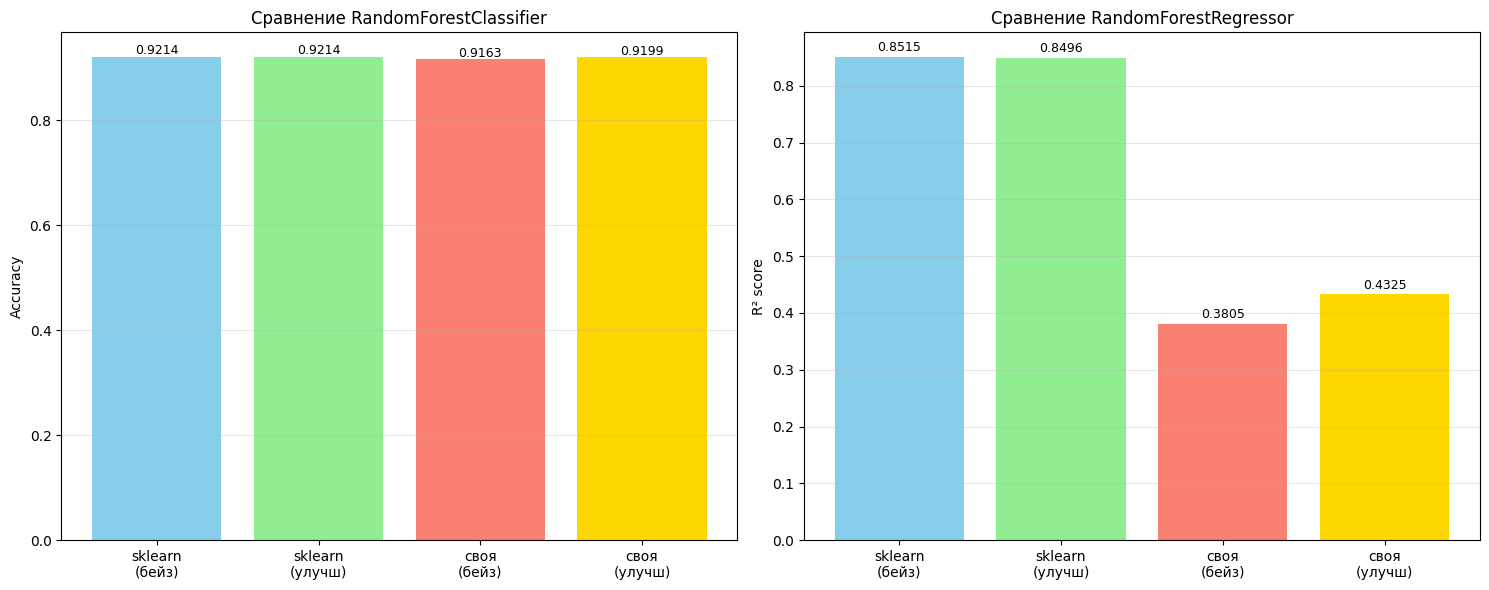

In [14]:
# -------------------- ИТОГОВОЕ СРАВНЕНИЕ --------------------
print("\n" + "="*70)
print("ИТОГОВОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ СЛУЧАЙНОГО ЛЕСА")
print("="*70)

print(f"\n{'Алгоритм':<30} {'Реализация':<15} {'Accuracy/R²':<15} {'F1/MAE (млн €)':<20}")
print(f"{'-'*30:<30} {'-'*15:<15} {'-'*15:<15} {'-'*20:<20}")

# Случайные леса классификация
print(f"\n{'RandomForestClassifier':<30} {'sklearn (бейз)':<15} {acc_rf_cls:<15.4f} {f1_rf_cls:<20.4f}")
print(f"{'':<30} {'sklearn (улучш)':<15} {acc_rf_cls_imp:<15.4f} {f1_rf_cls_imp:<20.4f}")
print(f"{'':<30} {'своя (бейз)':<15} {acc_my_rf_cls:<15.4f} {f1_my_rf_cls:<20.4f}")
print(f"{'':<30} {'своя (улучш)':<15} {acc_my_rf_cls_imp:<15.4f} {f1_my_rf_cls_imp:<20.4f}")

# Случайные леса регрессия
print(f"\n{'RandomForestRegressor':<30} {'sklearn (бейз)':<15} {r2_rf_reg:<15.4f} {mae_rf_reg/1_000_000:<20.2f}")
print(f"{'':<30} {'sklearn (улучш)':<15} {r2_rf_reg_imp:<15.4f} {mae_rf_reg_imp/1_000_000:<20.2f}")
print(f"{'':<30} {'своя (бейз)':<15} {r2_my_rf_reg:<15.4f} {mae_my_rf_reg/1_000_000:<20.2f}")
print(f"{'':<30} {'своя (улучш)':<15} {r2_my_rf_reg_imp:<15.4f} {mae_my_rf_reg_imp/1_000_000:<20.2f}")

# Визуализация итогового сравнения
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Сравнение классификации
models_cls = ['sklearn\n(бейз)', 'sklearn\n(улучш)', 'своя\n(бейз)', 'своя\n(улучш)']
acc_values_cls = [acc_rf_cls, acc_rf_cls_imp, acc_my_rf_cls, acc_my_rf_cls_imp]

bars1 = axes[0].bar(models_cls, acc_values_cls, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Сравнение RandomForestClassifier')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(acc_values_cls):
    axes[0].text(i, v + 0.005, f'{v:.4f}', ha='center', fontsize=9)

# Сравнение регрессии
models_reg = ['sklearn\n(бейз)', 'sklearn\n(улучш)', 'своя\n(бейз)', 'своя\n(улучш)']
r2_values_reg = [r2_rf_reg, r2_rf_reg_imp, r2_my_rf_reg, r2_my_rf_reg_imp]

bars2 = axes[1].bar(models_reg, r2_values_reg, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
axes[1].set_ylabel('R² score')
axes[1].set_title('Сравнение RandomForestRegressor')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(r2_values_reg):
    axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

